In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import corner

The data generating process, schematically, is
$$\lambda \to \left( \{ \theta_i \}, n \right) \stackrel{\text{Poisson}}{\sim} \frac{dN}{d\theta_i}(\theta_i | \lambda) \stackrel{\text{Gaussian noise}}\to \{d_i\} \sim \{ p(d_i | \theta_i) \}$$
with $i$ runs from $1$ to $n$ for $n$ observations.

To model this process, we start with the Poisson probability of generating *one* particular system in $d\theta_i$ interval:
$$p(\theta_i| \lambda, N )d\theta_i = e^{-dN_i} \frac{dN}{d\theta_i} d\theta_i$$
and the Poisson probability of not having systems in other intervals $d \theta_j$:
$$P_{\text{null}}(\lambda, N ) = e^{-dN_j}$$
The probability of generating $n$ systems are then
$$p(\{\theta_i \}| \lambda, N )\{d\theta_i\} = e^{-N(\lambda)} \left\{\frac{dN}{d\theta_i}d\theta_i\right\}$$
In the case of perfect observations, this is the likelihood function of $\lambda$ and $N$.

Often, we assume the normalisation of $\frac{dN}{d\theta_i}$ is independent of $\lambda$ in phenomenological models, as we only care about the shape of the distribution. However, this is not necessarily true when astrophyiscal models are considered. For simiplicity, we factor out $\frac{dN}{d\theta} = N p(\theta | \lambda)$ for constant $N$.

Let's have a gaussian example. Say we draw $N_{\text{obs}}$ from an expected number of $N=100$, which are distributed in a gaussian $\{ x_i \} \sim \mathcal{N}(\mu, \sigma)$ with $(\mu, \sigma) = (2, 4)$.

First, we create our dataset.

In [2]:
N_true = 1000
mu_true, sigma_true = 2, 4
Nobs = np.random.poisson(lam=N_true)
Xobs = np.random.normal(loc=2, scale=4, size=Nobs)
print(Xobs, Nobs)

[-2.23657088 -1.16739733  0.50747438 ...  4.724412    4.31070147
  6.72161149] 1025


Define our log likelihood. *Advice: always use log space to avoid overflows

In [3]:
def log_likelihood(mu, sigma, N, x):
    gaussian_lpdf = np.sum(-(mu - x)**2/2/sigma**2 - 0.5*np.log(2*np.pi) - np.log(sigma))
    return gaussian_lpdf + x.size*np.log(N) - N

The question then becomes a typical probabilistic sampling problem, in which there are many different ways specific for various settings. Say we only consider the mean and fix other parameters, we can even just plot the likelihood on a grid. 

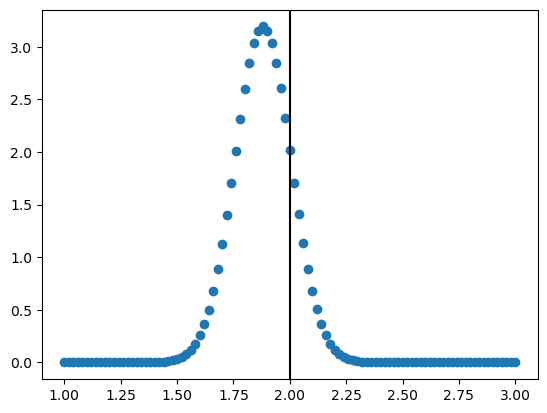

In [4]:
sigma, N = sigma_true, N_true
mus = np.linspace(1, 3, 101)
log_likes = np.zeros(mus.shape)
for i, mu in enumerate(mus):
    log_like = log_likelihood(mu, sigma, N, Xobs)
    log_likes[i] = log_like

### normalisation steps
log_likes -= log_likes.max()
likes_unnorm = np.exp(log_likes)
likes_norm = likes_unnorm/np.trapz(likes_unnorm, x=mus)
plt.scatter(mus, likes_norm, c='C0')
plt.axvline(x=mu_true, c='k')


We can also do an importance sampling for all three parameters, i.e., we first sample uniformly $(\mu, \sigma, N)$, calculate the corresponding *weights* of samples as the likelihood values, and make a histogram with these weights.

In [5]:
Nsamples = 10000
mu_samples, sigma_samples, N_samples = \
    np.random.uniform(Xobs.mean()*0.8, Xobs.mean()*1.2, Nsamples), \
    np.random.uniform(Xobs.std()*0.9, Xobs.std()*1.1, Nsamples), \
    np.random.uniform(Xobs.size*0.9, Xobs.size*1.1, Nsamples)

In [6]:
log_like_samples = np.zeros(Nsamples)
for i, (mu_, sigma_, N_) in enumerate(zip(mu_samples, sigma_samples, N_samples)):
    log_like_samples[i] = log_likelihood(mu_, sigma_, N_, Xobs)

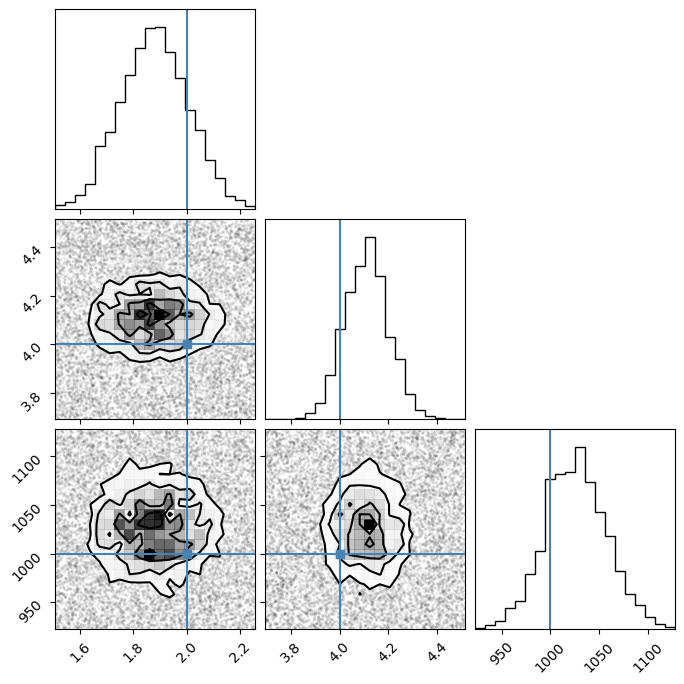

In [7]:
log_like_samples -= log_like_samples.max()
samples = np.transpose([mu_samples, sigma_samples, N_samples])
fig = corner.corner(samples, weights = np.exp(log_like_samples), truths=[mu_true, sigma_true, N_true])

Now, let's consider the measurement uncertainties. We need to modify the likelihood of $\lambda$ to include the likelihood of $\{ d_i \}$. To do so, we start with the joint distribution
$$p(\{\theta_i \}, \{ d_i \}| \lambda, N )\{ d\theta_i \} \{dd_i\} = p(\{ d_i \} | \{\theta_i\}, \lambda, N) \{ dd_i \} p(\{\theta_i \}| \lambda, N ) \{ d\theta_i \}$$
and notice that the data generation *conditioned* on the parameters only depends on the detector's noise and is independent of the Poisson process in the upper hierarchy:
$$p(\{ d_i \} | \{\theta_i\}, \lambda, N) = p(\{ d_i \} | \{\theta_i\})$$
Marginalising (i.e., integrating out the random variables) over $\{\theta_i\}$ gives
$$p(\{ d_i \}| \lambda, N ) = e^{-N(\lambda)} \prod_i^N \int p(d_i | \theta_i) \frac{dN}{d\theta_i} d\theta_i $$
Often, we only have access to the individual posterior samples. Thanks to Bayes' theorem, we can rewrite the individual likelihood as a quotient of the posterior and corresponding prior $\pi$:
$$p(\{ d_i \}| \lambda, N ) = e^{-N(\lambda)} \prod_i^n \int \frac{p(\theta_i|d_i )}{\pi(\theta_i)} \frac{dN}{d\theta_i} d\theta_i \approx e^{-N(\lambda)} \prod_i^n \left(\sum_j^m \frac{1}{\pi(\theta_{ij})} \frac{dN}{d\theta}(\theta_{ij}|\lambda) \right) $$
in which the last step is an importance sum approximation of the integrals using the posterior samples.

Now we revisit to the gaussian example. Say, the individual likelihood is also a gaussian with a constant uncertainty $\sigma_i$. A common mistake is to generate the mock likelihood/posterior samples with the true values aligning with the median or mean, which may introduce some bias when $n$ is large.

A proper way to create the injection is:
1. Draw $N_{\text{obs}}$ samples of $\{ \theta_{T, i} \}$ from $dN/d\theta$. These are the *true* samples.
2. Scatter the *observed values* by drawing $\{ \theta_{\text{obs}, i} \}$ from $p(d|\theta_{T, i})$ for each true sample.
3. Generate $N_{\text{samples}}$ likelihood (or posterior) samples by relocating the likelihood at observed values $\{ \theta_{\text{obs}, ij} \}$ from $p(d|\theta_{\text{obs}, i})$.

Note that this process may not be trivial in generating the gravitational wave mock catalog, as the scattering of the true values is solely inherited from the SNR fluctuation due to gaussian noise. The easiest way is of course to make actual injections, but we can discuss more for approximated methods if interested.

In [8]:
N_true = 1000
mu_true, sigma_true = 2, 4
Nobs = np.random.poisson(lam=N_true)
Xtrue = np.random.normal(loc=2, scale=4, size=Nobs)
like_ind_sigma = 3
# mock up likelihood: N(xtrue, 1.0)
Xobs = np.array([np.random.normal(loc=xtrue, scale = like_ind_sigma) for xtrue in Xtrue])

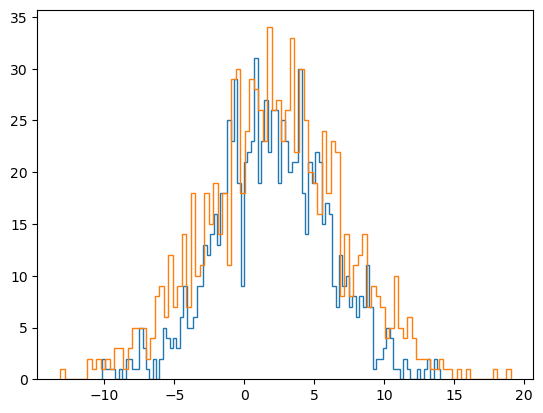

In [9]:
plt.hist(Xtrue, 100, histtype="step")
plt.hist(Xobs, 100, histtype="step")
plt.show()

In [10]:
N_ind_samples = 100
Xobs_likes = []
for xobs in Xobs:
    Xobs_likes.append(np.random.normal(loc=xobs, scale = like_ind_sigma, size=N_ind_samples))
Xobs_likes = np.array(Xobs_likes)

Now the function to evalute the hierarchical likelihood needs to be modified for the importance sum.

In [11]:
from scipy.special import logsumexp

In [12]:
def log_likelihood_importance_sum(mu, sigma, N, x_likes):
    Nobs = x_likes.shape[0]
    gaussian_lpdf_likes = -(mu - x_likes)**2/2/sigma**2 - 0.5*np.log(2*np.pi) - np.log(sigma)
    gaussian_lpdf_i = logsumexp(gaussian_lpdf_likes, axis=1)
    return np.sum(gaussian_lpdf_i) + Nobs*np.log(N) - N

In [13]:
Nsamples = 10000
mu_samples_IS, sigma_samples_IS, N_samples_IS = \
    np.random.uniform(mu_true*0.5, mu_true*1.5, Nsamples), \
    np.random.uniform(sigma_true*0.8, sigma_true*1.2, Nsamples), \
    np.random.uniform(Xobs.size*0.9, Xobs.size*1.1, Nsamples)

log_likelihood_IS = np.zeros(Nsamples)
for i, (mu_, sigma_, N_) in enumerate(zip(mu_samples_IS, sigma_samples_IS, N_samples_IS)):
    log_likelihood_IS[i] = log_likelihood_importance_sum(mu_, sigma_, N_, Xobs_likes)


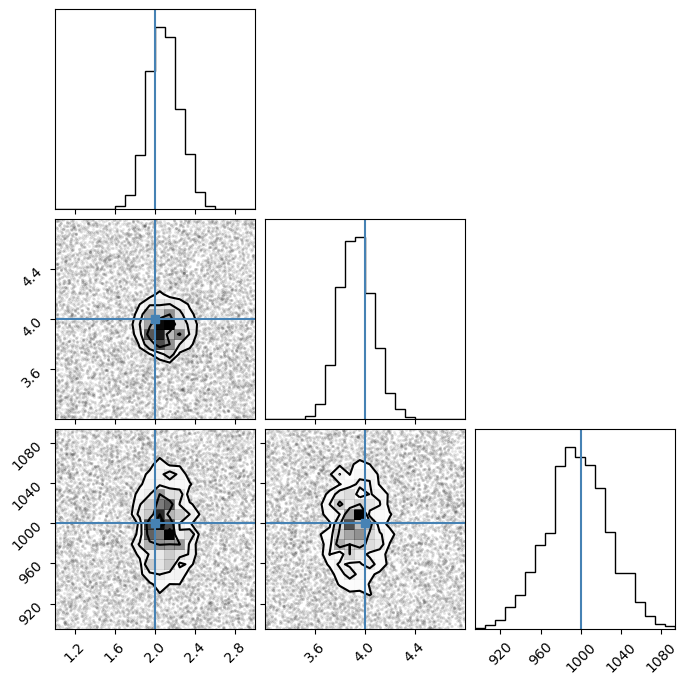

In [14]:
log_likelihood_IS -= log_likelihood_IS.max()
samples_IS = np.transpose([mu_samples_IS, sigma_samples_IS, N_samples_IS])
fig_IS = corner.corner(samples_IS, weights = np.exp(log_likelihood_IS), truths=[mu_true, sigma_true, N_true], c = 'C0')

Compare perfect vs non perfect:

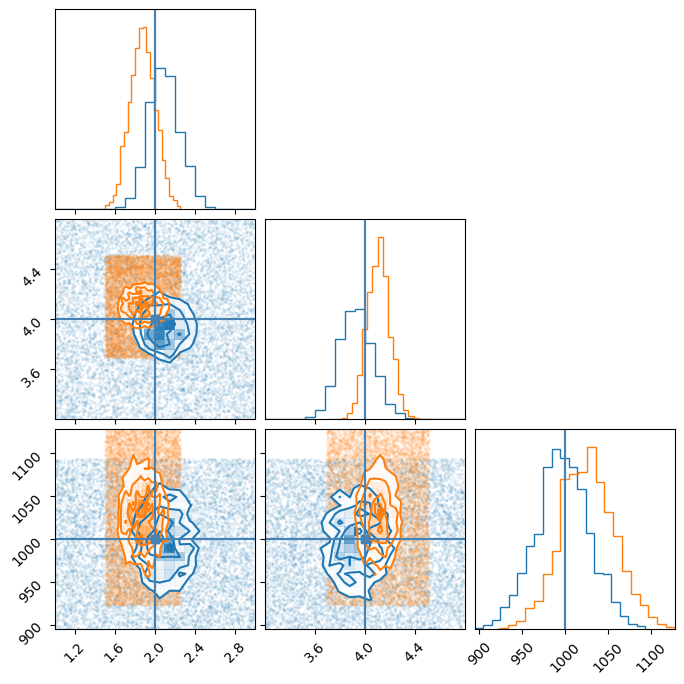

In [15]:
fig_comp_ = corner.corner(samples_IS, weights = np.exp(log_likelihood_IS), truths=[mu_true, sigma_true, N_true], color="C0", hist_kwargs={"density":True})
fig_comp = corner.corner(samples, weights = np.exp(log_like_samples), truths=[mu_true, sigma_true, N_true], color="C1", fig = fig_comp_, hist_kwargs={"density":True})

Under this formulism, the selection effect may be included by a little twist. Since the data chunks without suprathreshold signals contain subthreshold signals, we cannot use $P_{\text{null}}$ to model these data chunks. Instead, we consider the joint distribution of observed $\theta_i$ and unobserved $\theta_j$:
$$p(\{\theta_i \}, \{\theta_j \}| \lambda, N )\{d\theta_i\}\{d\theta_j\} = e^{-N(\lambda)} \left\{\frac{dN}{d\theta_i}d\theta_i\right\} \left\{\frac{dN}{d\theta_j}d\theta_j\right\}$$
and again we consider further the data with and without suprathreshold signals:
$$p(\{\theta_i \}, \{\theta_j \}, \{d_i\}, \{d_j\}| \lambda, N )\{d\theta_i\}\{d\theta_j\} = e^{-N(\lambda)} \left\{\frac{dN}{d\theta_i}p(d_i | \theta_i) d\theta_i\right\} \left\{\frac{dN}{d\theta_j}p(d_j|\theta_j)d\theta_j\right\}$$
and marginalise over the unobserved $\{\theta_j\}$ and $\{d_j\}$.
The marginalisation of $\{d_j\}$ is a bit subtle as the number of unobserved data is also unknown. More detailed mathematical treatment is shown in Eqs.(18-22) of arXiv:1809.02063. The end result is
$$p(\{ d_i \}| \lambda, N ) \propto e^{-N_{\text{det}}(\lambda)} \prod_i^n \int \frac{p(\theta_i|d_i )}{\pi(\theta_i)} \frac{dN}{d\theta_i} d\theta_i$$
with the modification in the exponent
$$N_{\text{det}}(\lambda) = \int \frac{dN}{d\theta}(\theta | \lambda)p_{\text{det}}(\theta) d\theta$$
It is a bit hard to guess this form intuitively, as the correction really comes from the unknown number of subthreshold data.

All the hard work really lies on the evaluation of $N_{\text{det}}$, as the detection probability $p_{\text{det}}$ is highly non-trivial in the case of GW searches with complex alogrithms. Typically, the working groups in LVK perform a huge injection campaign to approximate $p_{\text{det}}$ by a finite amount of selected samples, such that one can reweigh the injection prior and calculate the functional $N_{\text{det}}$, which is then the bottle-neck of the hierarchical likelihood precision.

Nonetheless, let's try a simplified example. We know that $\rho \propto 1/d_L$ in GW. Say, we try to fit the redshift distribution with $\rho(z=1) = \rho_{t}$ and take Euclidean spacetime such that $z=d_L$ (just keep it simple). Hence, $p_{\text{det}}$ is just a step function at $\rho_t$

In [16]:
rho_th, z_th = 8.0, 1.0
def rho(z, rho_th = rho_th, z_th= z_th):
    return rho_th*z_th/z

And our model is a log normal in redshift.

In [17]:
from scipy.stats import lognorm

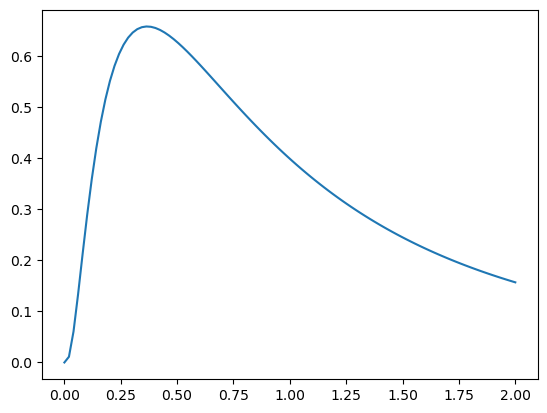

In [57]:
ln_sigma_true = 1.0
ln_mu_true = 0.0
zs = np.linspace(0.001, 2., 100)
plt.plot(zs, lognorm(s=ln_sigma_true, loc=ln_mu_true).pdf(zs))

First, consider the perfect case.

In [43]:
N_true = 1000
N = np.random.poisson(N_true)
z_obs = lognorm(s=ln_sigma_true).rvs(size=N)
z_detected = z_obs[rho(z_obs) >= rho_th]
print(z_obs.size, z_detected.size)

1042 524


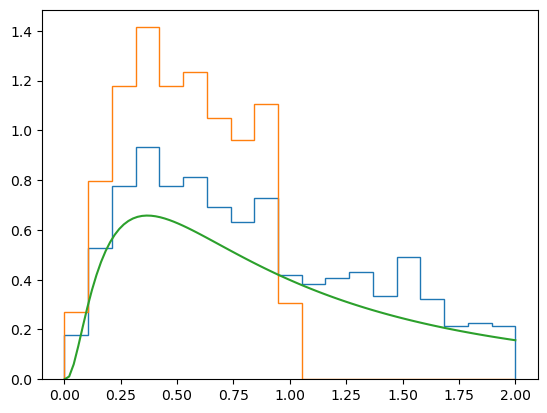

In [44]:
plt.hist(z_obs, np.linspace(0., 2, 20), density = True, histtype="step")
plt.hist(z_detected, np.linspace(0., 2, 20), density = True, histtype="step")
plt.plot(zs, lognorm(s=ln_sigma_true).pdf(zs))
plt.show()

Define the hierarchical likelihood w/ selection effect (or we call the *censored* likelihood)

In [21]:
from scipy.special import erf

In [51]:
def log_likelihood_sel(ln_sigma, ln_mu, N, z):
    Nobs = z.shape[0]
    lognorm_lpdf_i = -((np.log(z)-ln_mu)/ln_sigma)**2/2 - np.log(ln_sigma) - np.log(z) - 0.5*np.log(2*np.pi)
    Ndet = 0.5*(1+erf((np.log(z_th)-ln_mu)/ln_sigma/np.sqrt(2)))*N
    return np.sum(lognorm_lpdf_i) + Nobs*np.log(N) - Ndet

In [52]:
ln_sigmas = np.linspace(0.5, 2.0, 100)
ln_mus = np.linspace(-1, 1, 100)
log_likes = np.zeros(100)
for i, ln_mu in enumerate(ln_mus):
    log_likes[i] = log_likelihood_sel(ln_sigma_true, ln_mu, Nobs, z_detected)

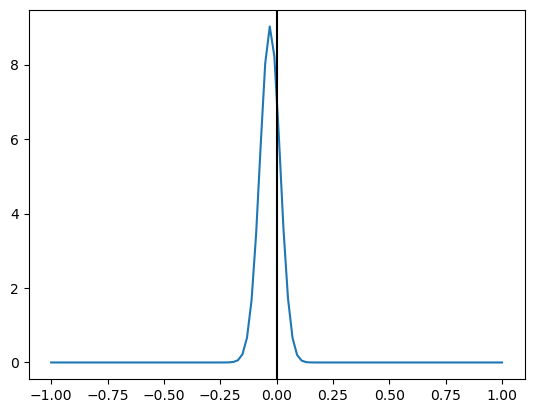

In [59]:
log_likes -= log_likes.max()
likes_unnorm = np.exp(log_likes)
likes_norm = likes_unnorm/np.trapz(likes_unnorm, x=ln_mus)

plt.plot(ln_mus, likes_norm)
plt.axvline(x = ln_mu_true, c='k')

Let's see what happens if we do not include selection effect.

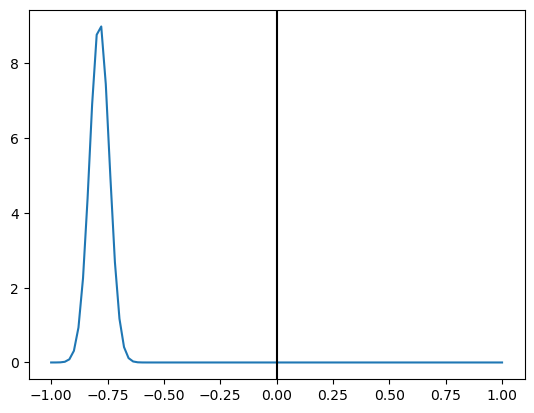

In [62]:
def log_likelihood_sel_wrong(ln_sigma, ln_mu, N, z):
    Nobs = z.shape[0]
    lognorm_lpdf_i = -((np.log(z)-ln_mu)/ln_sigma)**2/2 - np.log(ln_sigma) - np.log(z) - 0.5*np.log(2*np.pi)
    #Ndet = 0.5*(1+erf((np.log(z_th)-ln_mu)/ln_sigma/np.sqrt(2)))*N
    return np.sum(lognorm_lpdf_i) + Nobs*np.log(N) - N#det


ln_mus_wrong = np.linspace(-1, 1.0, 100)
log_likes_wrong = np.zeros(100)
for i, ln_mu in enumerate(ln_mus_wrong):
    log_likes_wrong[i] = log_likelihood_sel_wrong(ln_sigma_true, ln_mu, Nobs, z_detected)

log_likes_wrong -= log_likes_wrong.max()
likes_unnorm_wrong = np.exp(log_likes_wrong)
likes_norm_wrong = likes_unnorm_wrong/np.trapz(likes_unnorm_wrong, x=ln_mus_wrong)

plt.plot(ln_mus_wrong, likes_norm_wrong)
plt.axvline(x = ln_mu_true, c='k')

Let's say we are bad at theoretical probabilities, and we estimate the selection effect by importance sum:

In [80]:
ln_mu_base, ln_sigma_base = 0.1, 1.2
N_base = 10000
z_base_samples = lognorm(s=ln_sigma_base, loc=ln_mu_base).rvs(size=N_base)
z_base_selected = z_base_samples[rho(z_base_samples)>=rho_th]
logw_base_selected = lognorm(s=ln_sigma_base, loc=ln_mu_base).logpdf(z_base_selected)
fraction = z_base_selected.size/z_base_samples.size

In [81]:
def lognorm_lpdf(ln_sigma, ln_mu, z):
    return -((np.log(z)-ln_mu)/ln_sigma)**2/2 - np.log(ln_sigma) - np.log(z) - 0.5*np.log(2*np.pi)

def log_likelihood_sel_IS(ln_sigma, ln_mu, N, z, z_base_sel, logw_base_sel, fraction):
    Nobs = z.shape[0]
    lognorm_lpdf_i = lognorm_lpdf(ln_sigma, ln_mu, z)
    Ndet = N*np.mean(np.exp(lognorm_lpdf(ln_sigma, ln_mu, z_base_sel) - logw_base_sel)) *fraction
    return np.sum(lognorm_lpdf_i) + Nobs*np.log(N) - Ndet

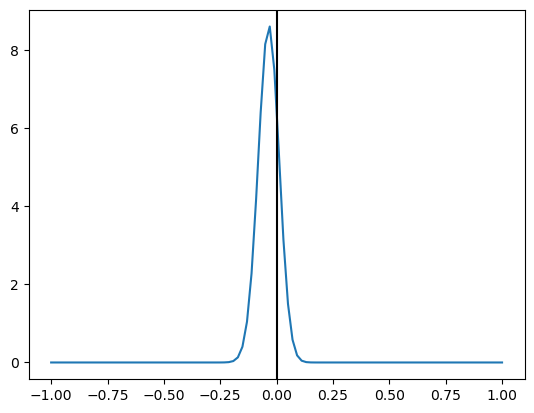

In [82]:
ln_sigmas = np.linspace(0.5, 2.0, 100)
ln_mus = np.linspace(-1, 1, 100)
log_likes_IS = np.zeros(100)
for i, ln_mu in enumerate(ln_mus):
    log_likes_IS[i] = log_likelihood_sel_IS(ln_sigma_true, ln_mu, Nobs, z_detected, z_base_selected, logw_base_selected, fraction)
log_likes_IS -= log_likes_IS.max()
likes_unnorm_IS = np.exp(log_likes_IS)
likes_norm_IS = likes_unnorm_IS/np.trapz(likes_unnorm_IS, x=ln_mus)

plt.plot(ln_mus, likes_norm_IS)
plt.axvline(x = ln_mu_true, c='k')